In [1]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import aesara.tensor as at
import xarray as xr



# The how and why of statistically modeling student *results*


#### UvA, DSC, October 2022

<img src=https://camo.githubusercontent.com/bcfd83328eafae3e264cd9b3e51fc92bb36ba5053cab6e2ec11f6bbf044f8a28/68747470733a2f2f63646e2e7261776769742e636f6d2f70796d632d646576732f70796d632f6d61696e2f646f63732f6c6f676f732f7376672f50794d435f62616e6e65722e737667 align=right>
 

### Marcel Haas, Business Intelligence @ Executive staff UvA
m.r.haas@uva.nl

<br>
<br>

*Collaborator: Colin Caprani (Monash University)*

<br>
<br>
<br>

Get material from [Github](https://github.com/UvA-DSC/20221021_seminar_BayesianStudents): https://github.com/UvA-DSC/20221021_seminar_BayesianStudents

# What to talk about?

<img src=https://static.thenounproject.com/png/1456735-200.png align=right width=300>


1. Bayesian Generative Modeling:

    1.1 What even is this Bayes thing?

    1.2 Simple modeling example
    

2. Student results as "continuous" Item-Response Theory problem

3. OK, now what?


# Baysian Generative *Modeling*

<img src=https://i.pinimg.com/736x/8f/c4/94/8fc4940161ba1bb786d9366dd16c022c--svg-file-fedora.jpg align=right width=600>

<br>

We are constructing a ***model*** that ***may*** have some connection to reality.

<br>

The reason for modeling is to ***learn*** about model building blocks, from ***observed data***.


# Bayesian *Generative* Modeling
<br>
<br>

<img src=https://notes.dsc80.com/_images/missing-mech.png align=center width=700>

<br>
<br>


We model the ***data generating process*** (forward modeling), assuming some ***prior knowledge***.

# *Bayesian* Generative Modeling

The knowledge about the data generating process is updated with the observed data, resulting in the current state of knowledge about the data generating process.

<img src=https://upload.wikimedia.org/wikipedia/commons/1/18/Bayes%27_Theorem_MMB_01.jpg align=center width=400>

Read this as 

$ P(\textrm{model given the data}) = P(\textrm{data given the model}) \cdot P(\textrm{model}) \cdot \textrm{Constant}$

### Or: Posterior probability distribution = Likelihood x Prior


# *Bayesian* Generative Modeling

Intermezzo: This posterior is ***really*** what you should want, when doing inference, not the likelihood.

Frequentist statistics and (often) machine learning give you a *Maximum Likelihood* estimate.

<img src=https://upload.wikimedia.org/wikipedia/commons/1/18/Bayes%27_Theorem_MMB_01.jpg align=center width=400>


# Bayesian *Generative modeling*

We model the **data generating process** (forward modeling), assuming some **prior knowledge**.

The knowledge about the data generating process is updated with the observed data, resulting in the current state of knowledge about the data generating process.

The Posterior ($P(\textrm{model given the data})$) is often complex and multi-dimensional.

Sampling the posterior, through prior and likelihood with a Monte Carlo Markov Chain:

<img src=https://www.researchgate.net/publication/338363810/figure/fig6/AS:843249581309953@1578057775228/Illustration-of-the-Markov-chain-Monte-Carlo-with-Metropolis-Hastings-MCMC-MH-procedure.png align=center width=500>



# Example!

We have two variables that are supposed to have a linear relationship, with positive slope and some intercept.

We'll fake some data and pretend we don't know how we did it...

(After [this more elaborate notebook](https://github.com/harcel/BiteSizeDataScience/blob/main/0_LinearRegressionThreeWays/Linear_regression_3ways.ipynb))

In [4]:
# Parameters about the data:
size = 20   # number of data points
true_intercept = 4
true_slope = 6

# Create the independent variable
x = np.linspace(0, 1, size)
# Create the independent variable y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise, drawn from a Gaussian (from numpy) with mean 0 and a standard deviation of 0.5
np.random.seed(123)
y = true_regression_line + np.random.normal(scale=.5, size=size)

# Here's what it looks like!

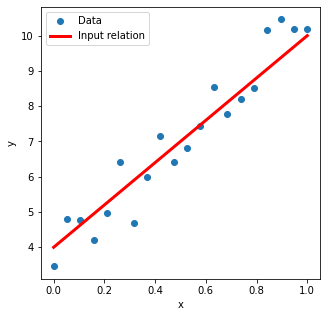

In [5]:
plt.figure(figsize=(5,5))
plt.scatter(x, y, label='Data')
plt.plot(x, true_regression_line, color='red', linewidth=3, label='Input relation')
plt.legend()
plt.xlabel('x'); plt.ylabel('y');

# Linear regression the traditional way

One could just simply do this with `statsmodels` or `scikit-learn`:

In [7]:
import statsmodels.api as sm
X = sm.add_constant(x, prepend=True)
smreg = sm.OLS(y, X)
smres = smreg.fit()
print(smres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     234.4
Date:                Mon, 04 Jul 2022   Prob (F-statistic):           9.16e-12
Time:                        21:29:35   Log-Likelihood:                -17.074
No. Observations:                  20   AIC:                             38.15
Df Residuals:                      18   BIC:                             40.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6792      0.258     14.254      0.0

In [9]:
from sklearn.linear_model import LinearRegression
x_in = x.reshape(-1,1)
regr = LinearRegression()
regr.fit(x_in, y)
print(f'Slope {regr.coef_[0]:3.2f} and intercept {regr.intercept_:3.2f}')


Slope 6.76 and intercept 3.68


They better agree: linear regression is a deterministic process.

# Example, the Bayesian generative way

We construct a model, and then sample the posterior:

1. Assume priors (can be *uninformative*!)

    -> There's a slope, an intercept, and noise (Gaussian with positive $\sigma$)
    
    
2. Define the relation between variables (observed and latent)

In [ ]:
import pymc as pm

with pm.Model() as linreg:
    # 1. Priors!
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('Slope', 0, sigma=20)
    sigma = pm.HalfCauchy('sigma', beta=10)

    # 2. Relationships!
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x,
                        sigma=sigma, observed=y)

NameError: name 'x' is not defined

Take special note of the `observed=` keyword in the last line!

# Example, the Bayesian generative way

We construct a model, and then sample the posterior:

1. Assume priors (can be *uninformative*!)
2. Define the relation between variables (observed and latent)
3. Pick a sampler for the posterior
4. Sample your heart out 
5. Inspect!

In [12]:
with linreg:
    # 3. Pick a sampler, don't worry for now.
    step = pm.NUTS()
    
    # 4. Sample! Aka: The Inference button.
    trace = pm.sample(2000, cores=2, tune=2000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Slope, sigma]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


# Basic statistics of the posterior(s)

In [13]:
print(pm.summary(trace)) # A summary of the results for all stochastic variables

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  3.671  0.284   3.100    4.182      0.008    0.006    1245.0   
Slope      6.766  0.482   5.840    7.668      0.014    0.010    1239.0   
sigma      0.642  0.121   0.434    0.852      0.003    0.002    1437.0   

           ess_tail  r_hat  
Intercept    1836.0    1.0  
Slope        1640.0    1.0  
sigma        1198.0    1.0  


# Let's have a look

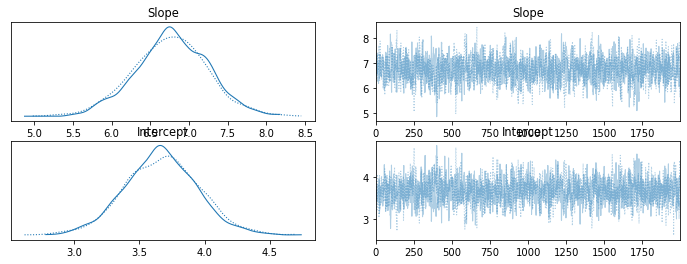

In [19]:
# Plotting functionality for traces is provided by the package Arviz
az.plot_trace(trace, var_names=['Slope', 'Intercept']);

# Free goodies: the joint posterior

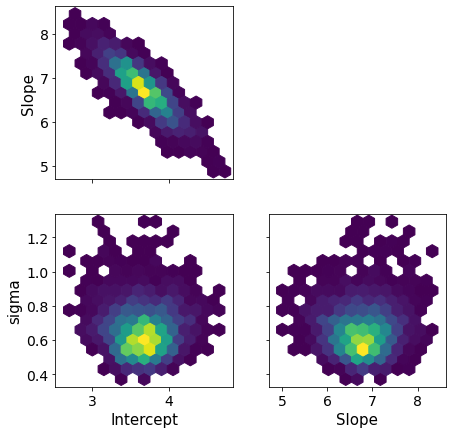

In [20]:
az.plot_pair(trace, kind='hexbin', figsize=(7,7));

Note the areas of ~zero posterior probability! Try to find *that* with statsmodels or scikit-learn!

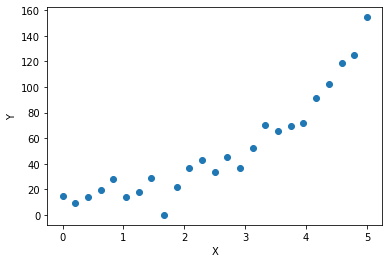

In [2]:
npoints = 25
x_data = np.linspace(0,5, npoints)
y_data = np.clip(x_data**3 + 20 + np.random.normal(scale=10, size=npoints), 0, None)
plt.scatter(x_data, y_data)
plt.xlabel('X')
plt.ylabel('Y');

In [3]:
with pm.Model() as flat_lin:
    # Priors
    x_coeff = pm.HalfNormal('Slope', sigma=30)
    const = pm.HalfNormal('Constant', sigma=20)
    switchpoint = pm.Uniform('Switchpoint', lower=np.percentile(x_data, 20), upper=np.percentile(x_data, 80))
        
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Relationships
    lin_part = x_data * x_coeff + switchpoint*x_coeff - const
    y_ref = pm.math.switch(at.gt(switchpoint, x_data), const, lin_part)
    
    likelihood = pm.Normal('Y', mu=y_ref, sigma=sigma, observed=y_data)
    
    trace_ex = pm.sample(tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Slope, Constant, Switchpoint, sigma]


Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 48 seconds.


array([[<AxesSubplot:title={'center':'Slope'}>,
        <AxesSubplot:title={'center':'Slope'}>],
       [<AxesSubplot:title={'center':'Constant'}>,
        <AxesSubplot:title={'center':'Constant'}>],
       [<AxesSubplot:title={'center':'Switchpoint'}>,
        <AxesSubplot:title={'center':'Switchpoint'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

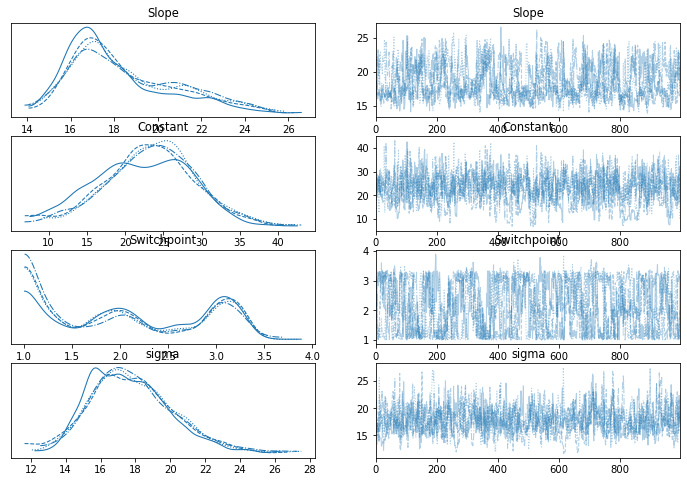

In [4]:
az.plot_trace(trace_ex)

In [57]:
#az.plot_pair(trace_ex, kind='kde')
trace_ex.posterior["x_fine"] = xr.DataArray(np.linspace(0,5, 100))
trace_ex.posterior["y_model"] = pm.math.switch(
    at.gt(trace_ex.posterior["Switchpoint"], trace_ex.posterior["x_fine"]),
    trace_ex.posterior["Constant"],
    trace_ex.posterior["Switchpoint"]*trace_ex.posterior["Slope"] - trace_ex.posterior["Constant"] + trace_ex.posterior["Slope"] * xr.DataArray(x))

az.plot_lm("Y", idata=trace_ex, x=trace_ex.posterior["x_fine"], y_model=trace_ex.posterior["y_model"])

NotImplementedError: Cannot convert <xarray.DataArray 'Switchpoint' (chain: 4, draw: 1000)>
array([[3.08757867, 2.88597689, 2.62756208, ..., 2.93216057, 3.03149938,
        2.69931628],
       [3.24470321, 3.23529631, 3.16926972, ..., 2.93105453, 3.02691871,
        3.05599639],
       [3.21486707, 3.20788896, 3.23030364, ..., 3.06609427, 3.2176384 ,
        3.15522985],
       [3.09765582, 3.09765582, 2.91894974, ..., 3.18613126, 3.18613126,
        3.18613126]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999 to a tensor variable.

In [55]:
trace_ex.posterior.keys()

KeysView(<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    Slope        (chain, draw) float64 18.06 17.5 15.49 ... 16.17 16.17 16.17
    Constant     (chain, draw) float64 31.52 31.9 17.01 ... 24.62 24.62 24.62
    Switchpoint  (chain, draw) float64 3.088 2.886 2.628 ... 3.186 3.186 3.186
    sigma        (chain, draw) float64 14.68 22.04 15.78 ... 11.63 11.63 11.63
Attributes:
    created_at:                 2022-09-04T12:21:00.620538
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.0.1
    sampling_time:              33.54864311218262
    tuning_steps:               10000)

# Application!
## Modeling student results in networks

1. Students take courses, including electives, in variously composed groups
2. Students get grades that are a result of their ability and the test/course difficulty

<br>
<br>
<br>

Therefore, in principle, we can derive difficulty and ability for many students over many courses simultaneously.

# Grades

Theory of grades with equations and some plots.

# Simple experiments

# Conclusion from experiments